# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [7]:
data = pd.read_csv('datasets/Churn.csv')
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


столбец с индексом строки будет мешать обучению модели

In [10]:
data.drop('RowNumber', axis=1, inplace=True);

In [12]:
data.shape

(10000, 13)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


### Заполнение модой

In [12]:
data.Tenure = data.Tenure.fillna(data.Tenure.mode()[0])
data.Tenure.value_counts()

Tenure
1.0     1861
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: count, dtype: int64

### Построение гистограмм для каждого числового столбца

In [14]:
numeric_columns = data.select_dtypes(include='number').drop(['Exited', 'CustomerId'], axis=1).columns
numeric_columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

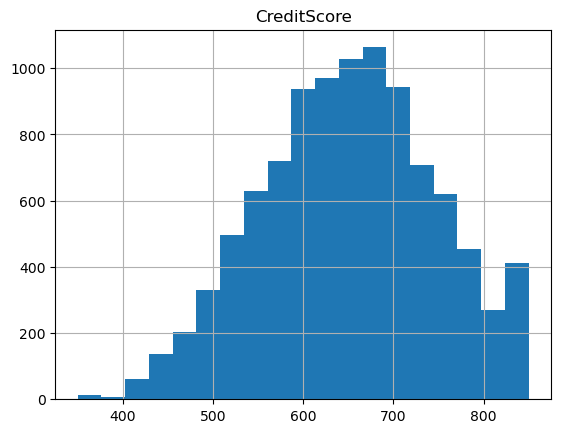

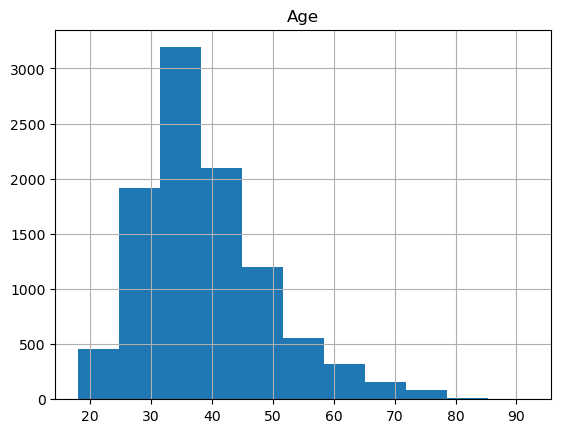

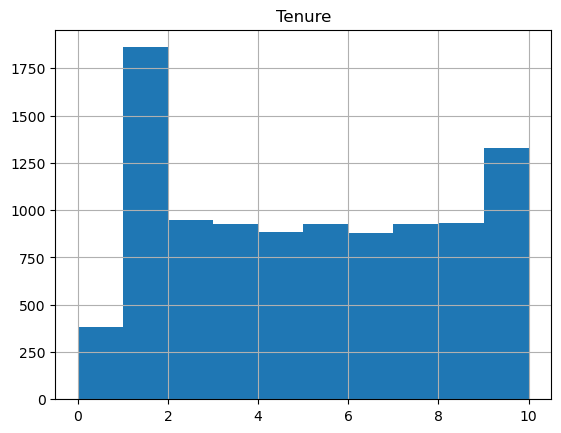

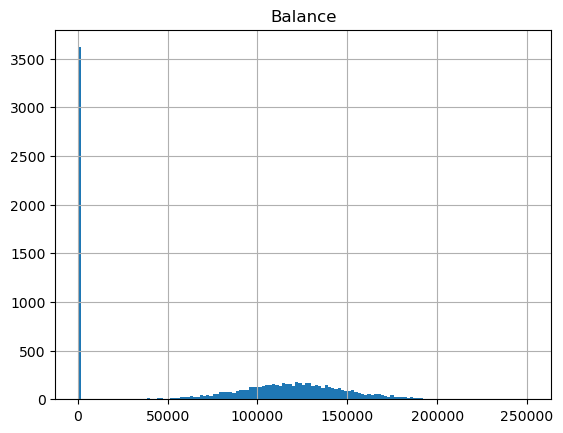

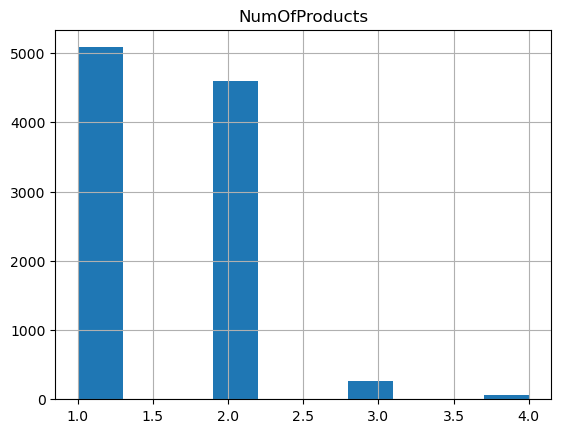

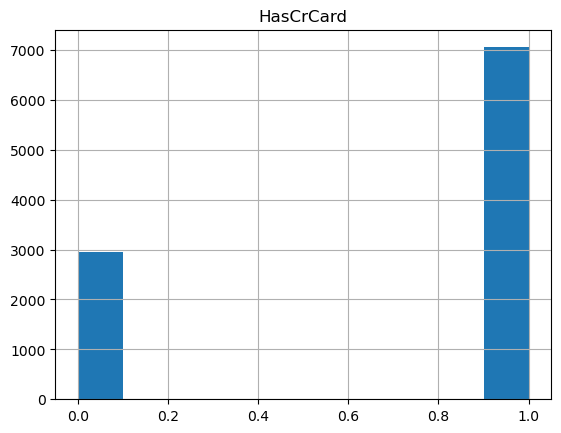

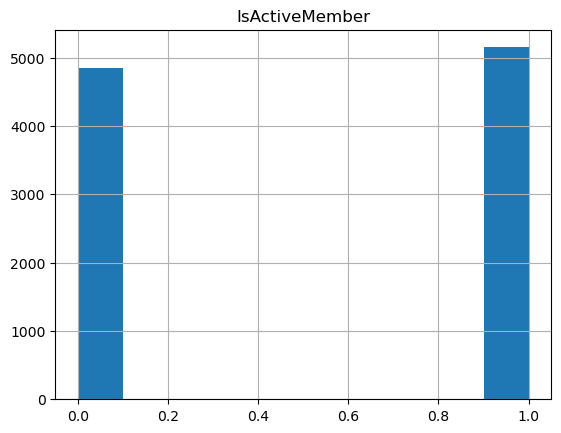

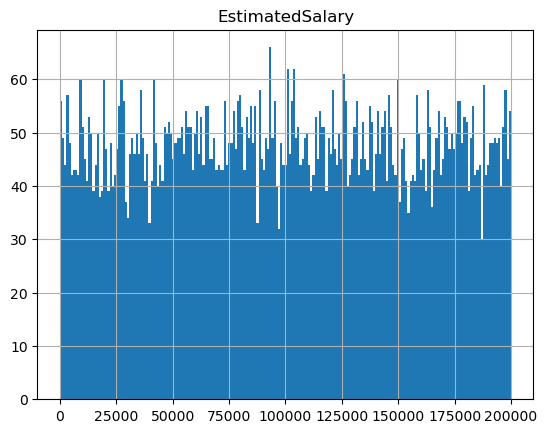

In [15]:
for i in numeric_columns:
    data[i].hist(bins=data[i].nunique()//50 + 10)
    plt.title(i)
    plt.show()

## Исследование задачи

### Разделение на выборки

In [18]:
features_train, features_temp, target_train, target_temp = train_test_split(
    data.drop('Exited', axis=1), 
    data.Exited, 
    stratify=data.Exited,
    test_size=0.4,
    random_state=12345
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, 
    target_temp, 
    stratify=target_temp,
    test_size=0.40,
    random_state=12345
)
target_train.value_counts(), target_valid.value_counts(), target_test.value_counts()

(Exited
 0    4778
 1    1222
 Name: count, dtype: int64,
 Exited
 0    1911
 1     489
 Name: count, dtype: int64,
 Exited
 0    1274
 1     326
 Name: count, dtype: int64)

### Преобразование признаков

In [20]:
categorical_columns = ['Geography', 'Gender']

In [145]:
features_train.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')

In [22]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='error', min_frequency=0.005), categorical_columns)
])
features_train_transformed = preprocessor.fit_transform(features_train)
features_valid_transformed = preprocessor.transform(features_valid)
features_test_transformed = preprocessor.transform(features_test)

### Обучение модели случайного леса

In [24]:
tree_model = RandomForestClassifier(n_estimators=160, max_depth=10, random_state=12345, class_weight='balanced')
tree_model.fit(features_train_transformed, target_train)
predicted_valid = tree_model.predict(features_valid_transformed)
probs_valid = tree_model.predict_proba(features_valid_transformed)[:, 1]
f1_score(target_valid, predicted_valid)

0.6317907444668008

In [25]:
roc_auc_score(target_valid, probs_valid)

0.8696321693692421

In [26]:
precision_score(target_valid, predicted_valid), recall_score(target_valid, predicted_valid)

(0.6217821782178218, 0.6421267893660532)

In [27]:
pd.Series(predicted_valid).value_counts()

0    1895
1     505
Name: count, dtype: int64

### Регулировка порога

In [29]:
best_th = 0
best_f1 = 0
for th in np.arange(0.1, 0.55, 0.05):
    predicted_custom = probs_valid > th
    f1 = f1_score(target_valid, predicted_custom)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
    print(f'threshold: {th}, f1: {f1}')

threshold: 0.1, f1: 0.39010543390105434
threshold: 0.15000000000000002, f1: 0.4336569579288026
threshold: 0.20000000000000004, f1: 0.47212089630015636
threshold: 0.25000000000000006, f1: 0.5188679245283019
threshold: 0.30000000000000004, f1: 0.5698704839809134
threshold: 0.3500000000000001, f1: 0.6165527714502658
threshold: 0.40000000000000013, f1: 0.6413502109704642
threshold: 0.45000000000000007, f1: 0.6456984273820536
threshold: 0.5000000000000001, f1: 0.6317907444668008


In [30]:
best_f1, best_th

(0.6456984273820536, 0.45000000000000007)

### ROC-кривая

Text(0.5, 1.0, 'ROC-кривая')

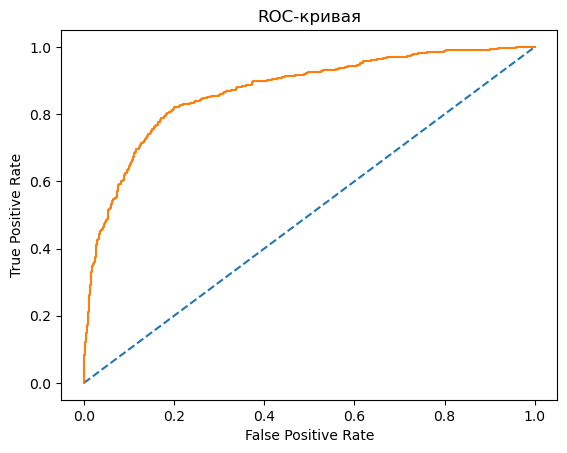

In [32]:
tpr, fpr, threshold = roc_curve(target_valid, probs_valid)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(tpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

### PR-кривая

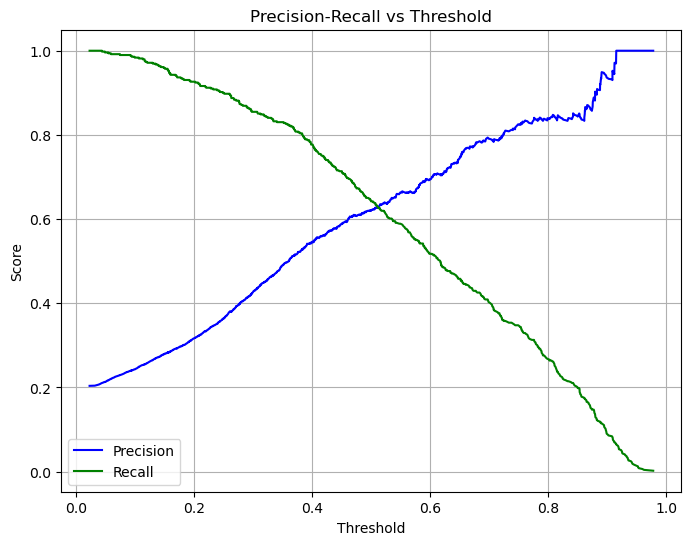

In [34]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(target_valid, probs_valid)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Кросс валидация

In [36]:
features_transformed = preprocessor.transform(data.drop('Exited', axis=1))
predicted_cv = cross_val_predict(tree_model, features_transformed, data.Exited)
f1_score(data.Exited, predicted_cv)

0.6176961602671118

In [98]:
cross_val_score(tree_model, features_transformed, data.Exited, scoring='f1').mean()

0.6176829906336779

## Борьба с дисбалансом (SMOTE)

In [39]:
smote = SMOTE(random_state=12345)
features_resampled, target_resampled = smote.fit_resample(features_train_transformed, target_train)
target_resampled.value_counts()

Exited
0    4778
1    4778
Name: count, dtype: int64

In [40]:
tree_model_smote = RandomForestClassifier(n_estimators=160, max_depth=10, random_state=12345)
tree_model_smote.fit(features_resampled, target_resampled)
predicted_valid_smote = tree_model_smote.predict(features_valid_transformed)
probs_valid_smote = tree_model_smote.predict_proba(features_valid_transformed)[:, 1]
f1_score(target_valid, predicted_valid_smote)

0.6356435643564357

In [41]:
roc_auc_score(target_valid, probs_valid_smote)

0.8674716071736228

In [42]:
precision_score(target_valid, predicted_valid_smote), recall_score(target_valid, predicted_valid_smote)

(0.6161228406909789, 0.656441717791411)

In [43]:
pd.Series(predicted_valid_smote).value_counts()

0    1879
1     521
Name: count, dtype: int64

## GridSearchCV

In [45]:
forest_model = RandomForestClassifier(class_weight='balanced', random_state=12345)

params = {
    'n_estimators': [170, 180],
    'max_depth': [10],
    'min_samples_split': [8, 9, 10],
}

grid = GridSearchCV(forest_model, params, n_jobs=-1, verbose=5, scoring='f1')
grid.fit(features_train_transformed, target_train)
grid.best_params_, grid.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


({'max_depth': 10, 'min_samples_split': 9, 'n_estimators': 180},
 0.61521495761482)

### Получение лучшей модели

In [46]:
best_forest_model = grid.best_estimator_
predicted_valid = best_forest_model.predict(features_valid_transformed)
probs_valid = best_forest_model.predict_proba(features_valid_transformed)[:, 1]
f1_score(target_valid, predicted_valid)

0.6443349753694582

In [47]:
roc_auc_score(target_valid, probs_valid)

0.8734749523531292

In [48]:
precision_score(target_valid, predicted_valid), recall_score(target_valid, predicted_valid)

(0.6216730038022814, 0.6687116564417178)

### Регулировка порога

In [103]:
best_th = 0
best_f1 = 0
for th in np.arange(0.1, 0.55, 0.05):
    predicted_custom = probs_valid > th
    f1 = f1_score(target_valid, predicted_custom)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
    print(f'threshold: {th}, f1: {f1}')

threshold: 0.1, f1: 0.38287752675386444
threshold: 0.15000000000000002, f1: 0.42030276046304543
threshold: 0.20000000000000004, f1: 0.4610748367654445
threshold: 0.25000000000000006, f1: 0.5117883841288097
threshold: 0.30000000000000004, f1: 0.5597897503285151
threshold: 0.3500000000000001, f1: 0.6038291605301914
threshold: 0.40000000000000013, f1: 0.6456953642384106
threshold: 0.45000000000000007, f1: 0.6525345622119816
threshold: 0.5000000000000001, f1: 0.6443349753694582


In [105]:
best_f1, best_th

(0.6525345622119816, 0.45000000000000007)

### ROC-кривая

Text(0.5, 1.0, 'ROC-кривая')

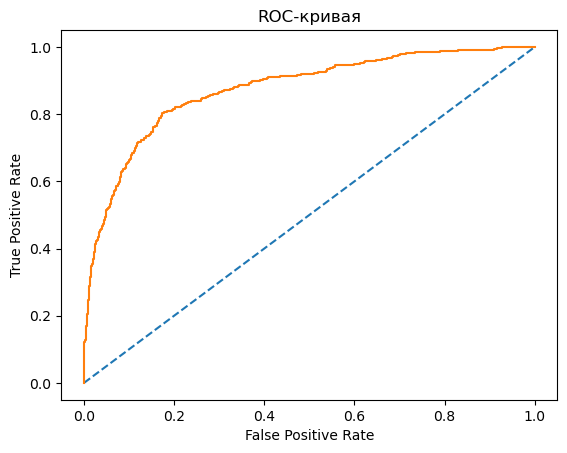

In [50]:
tpr, fpr, threshold = roc_curve(target_valid, probs_valid)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(tpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

### F1-кривая

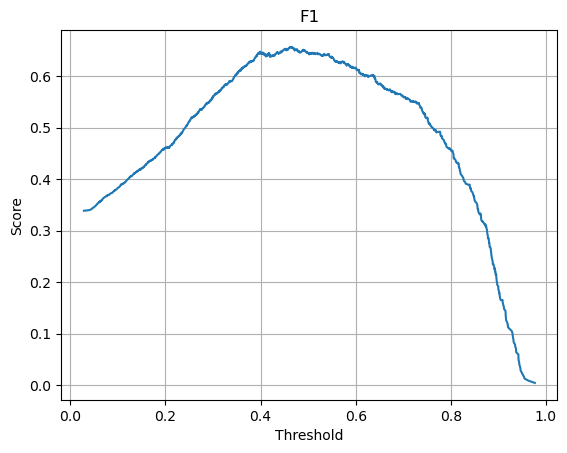

In [141]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(target_valid, probs_valid)
f1 = 2*precision*recall / (precision + recall)
plt.plot(thresholds, f1[:-1])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1')
plt.grid(True)
plt.show()

## SMOTE with GridSearchCV in Pipeline

In [164]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='error', min_frequency=0.005), categorical_columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=12345)),
    ('classifier', RandomForestClassifier(random_state=12345))
])

params = {
    'classifier__n_estimators': [140, 150, 160],
    'classifier__max_depth': [10],
    'classifier__min_samples_split': [12, 14, 16],
    'classifier__min_samples_leaf': [3]
}

grid = GridSearchCV(pipeline, params, n_jobs=-1, scoring='f1')
grid.fit(features_train, target_train)
grid.best_params_, grid.best_score_

({'classifier__max_depth': 10,
  'classifier__min_samples_leaf': 3,
  'classifier__min_samples_split': 12,
  'classifier__n_estimators': 150},
 0.6155106298422888)

### Получение лучшей модели

In [191]:
pipe_forest_model = grid.best_estimator_
pred_valid = pipe_forest_model.predict(features_valid)
probs_val = pipe_forest_model.predict_proba(features_valid)[:, -1]
f1_score(target_valid, pred_valid)

0.6430678466076696

In [173]:
roc_auc_score(target_valid, probs_val)

0.868700099199661

In [189]:
precision_score(target_valid, pred_valid), recall_score(target_valid, pred_valid)

(0.6193181818181818, 0.6687116564417178)

In [214]:
best_th = 0
best_f1 = 0
for th in np.arange(0.3, 0.7, 0.05):
    predicted_custom = probs_val > th
    f1 = f1_score(target_valid, predicted_custom)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
    print(f'threshold: {th}, f1: {f1}')

threshold: 0.3, f1: 0.5751544269045985
threshold: 0.35, f1: 0.6116207951070336
threshold: 0.39999999999999997, f1: 0.6352941176470588
threshold: 0.44999999999999996, f1: 0.639269406392694
threshold: 0.49999999999999994, f1: 0.6430678466076696
threshold: 0.5499999999999999, f1: 0.6270833333333333
threshold: 0.5999999999999999, f1: 0.6084070796460177
threshold: 0.6499999999999999, f1: 0.5909090909090909


In [216]:
best_f1, best_th

(0.6430678466076696, 0.49999999999999994)

## Тестирование модели

In [54]:
f1_score(target_test, tree_model.predict(features_test_transformed))

0.5780525502318392

In [55]:
f1_score(target_test, tree_model_smote.predict(features_test_transformed))

0.591044776119403

In [56]:
f1_score(target_test, best_forest_model.predict(features_test_transformed))

0.5969696969696969

In [218]:
f1_score(target_test, pipe_forest_model.predict(features_test))

0.5946745562130178

### Оценка качества лучшей модели с порогом 0.45

In [265]:
threshold = 0.45
probs_test = best_forest_model.predict_proba(features_test_transformed)[:, -1]
pred_test = probs_test > threshold
f1_score(target_test, pred_test)

0.5911602209944752

## Выводы

Лучше всего на тестовых данных себя показала модель best_forest_model с порогом 0.5, обученная без использования SMOTE:

In [268]:
best_forest_model

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=9, n_estimators=180,
                       random_state=12345)